In [1]:
import torch

import networkx as nx

import numpy as np
    
import pandas as pd

from tqdm.notebook import tqdm

import pickle

from tensorly.decomposition import tucker, constrained_parafac

import matplotlib.pyplot as plt

import scipy.io

# Old Tensor Creation Code

In [4]:
df = pd.read_csv('edges.csv', header=None)
df.head()

,0,1
0,1,176
1,1,233
2,1,283
3,1,371
4,1,394


In [5]:
G=nx.from_pandas_edgelist(df, 0, 1).to_undirected()

In [7]:
str(G)

'Graph with 10312 nodes and 333983 edges'

(array([3.934e+03, 2.400e+01, 1.000e+01, 9.000e+00, 0.000e+00, 4.000e+00,
        2.000e+00, 3.000e+00, 2.000e+00, 5.000e+00]),
 array([  0. ,  37.3,  74.6, 111.9, 149.2, 186.5, 223.8, 261.1, 298.4,
        335.7, 373. ]),
 <BarContainer object of 10 artists>)

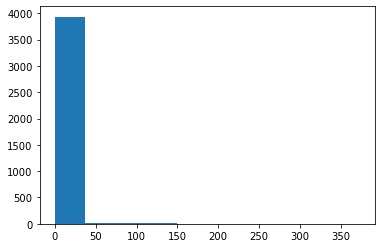

In [8]:
plt.hist(nx.degree_histogram(G))

In [9]:
np.unique(nx.degree_histogram(G), return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  24,  25,  26,
         27,  29,  30,  31,  32,  34,  36,  37,  38,  39,  41,  42,  43,
         46,  48,  49,  54,  58,  59,  60,  61,  62,  66,  68,  71,  75,
         80,  87,  89,  90,  93,  94, 108, 114, 115, 121, 131, 136, 137,
        143, 144, 145, 193, 195, 199, 219, 225, 228, 270, 277, 287, 310,
        322, 352, 354, 368, 371, 373]),
 array([3417,  236,   75,   39,   33,   22,   11,   12,    7,    7,   11,
           5,    6,    4,    3,    3,    3,    3,    3,    3,    1,    1,
           6,    4,    1,    3,    5,    1,    1,    2,    2,    1,    2,
           1,    1,    1,    2,    1,    3,    1,    2,    1,    2,    1,
           2,    1,    1,    1,    1,    1,    2,    2,    1,    1,    1,
           1,    2,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
    

In [10]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_graphs = []

    max_graph = 0

    for i in tqdm(range(G.number_of_nodes())):
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_graphs.append(G_ego)
            if max_graph < G_ego.number_of_nodes():
                max_graph = G_ego.number_of_nodes()

    return G, ego_graphs, max_graph


In [11]:
_, ego_gs, max_size = load_bc_data(G)

  0%|          | 0/10312 [00:00<?, ?it/s]

In [12]:
print(f'Using {len(ego_gs)} egonets')

Using 10312 egonets


In [13]:
saved_model = open('egonets.sav', 'wb')
pickle.dump(ego_gs, saved_model)
saved_model.close()

In [2]:
with open('egonets.sav', 'rb') as f:
    ego_gs = pickle.load(f)
    f.close()

In [14]:
slice_size = 1000

In [15]:
cube = torch.empty((1, slice_size, slice_size, slice_size))

In [16]:
for i in tqdm(range(len(ego_gs[:slice_size]))):
    slice_gs = nx.to_numpy_array(ego_gs[i])[:slice_size, :slice_size]
    result = np.zeros((len(ego_gs[:slice_size]), len(ego_gs[:slice_size])))
    result[:slice_gs.shape[0],:slice_gs.shape[1]] = slice_gs
    
    ten = torch.as_tensor(result)
    dim = ten.shape[0]
    cube[0, :dim, :dim, i] = ten

  0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
saved_model = open('clean_tensor_sep.sav', 'wb')
pickle.dump(cube, saved_model)
saved_model.close()

In [40]:
# with open('clean_tensor.sav', 'rb') as f:
#     cube = pickle.load(f)
#     f.close()

In [18]:
result = tucker(cube[0].numpy(), rank=10)

/Users/zubairqazi/miniconda3/envs/anom_detect/lib/python3.9/site-packages/tensorly/tucker_tensor.py:380: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 3. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


In [19]:
saved_model = open('decomp.sav', 'wb')
pickle.dump(result, saved_model)
saved_model.close()

In [3]:
with open('decomp.sav', 'rb') as f:
    result = pickle.load(f)
    f.close()

In [18]:
core, factors = result

# Building Clean Tensor with Anomalous data
Using original data (blogcatalog.mat) to create "clean" tensor

In [2]:
def load_bc_data():
    
    bc_data = scipy.io.loadmat("datasets/blogcatalog.mat")

    G = nx.from_scipy_sparse_array(bc_data["Network"])
    # nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
    print(str(G))

    # convert list of lists to list
    labels = [j for i in bc_data["Label"] for j in i]

    # Add labels to each node
    for i in range(len(G.nodes)):
        G.nodes[i]['Anomaly'] = labels[i]

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)

    return G, ego_gs, roots

In [3]:
G, ego_gs, roots = load_bc_data()

roots = [int(r) for r in roots]

Graph with 5196 nodes and 172897 edges


  0%|          | 0/5196 [00:00<?, ?it/s]

In [4]:
anom_gs, clean_gs = [], []
for idx, root_attr in enumerate(tqdm(roots)):
    if root_attr == 1:
        anom_gs.append(ego_gs[idx])
    else:
        clean_gs.append(ego_gs[idx])
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 298/5196
# of clean graphs: 4898/5196


In [5]:
slice_size = 1000
cube = torch.empty((1, slice_size, slice_size, slice_size))

In [6]:
for i in tqdm(range(len(clean_gs[:slice_size]))):
    slice_gs = nx.to_numpy_array(ego_gs[i])[:slice_size, :slice_size]
    result = np.zeros((len(ego_gs[:slice_size]), len(ego_gs[:slice_size])))
    result[:slice_gs.shape[0],:slice_gs.shape[1]] = slice_gs
    
    ten = torch.as_tensor(result)
    dim = ten.shape[0]
    cube[0, :dim, :dim, i] = ten

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
saved_model = open('cl_tens_mod.sav', 'wb')
pickle.dump(cube, saved_model)
saved_model.close()

In [10]:
# tucker decomposition

result = tucker(cube[0].numpy(), rank=30)

/Users/zubairqazi/miniconda3/envs/anom_detect/lib/python3.9/site-packages/tensorly/tucker_tensor.py:380: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 3. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


In [ ]:
saved_model = open('tk_decomp_mod.sav', 'wb')
pickle.dump(result, saved_model)
saved_model.close()

In [18]:
weight, factors = constrained_parafac(cube[0].numpy(), rank=1)

In [15]:
saved_model = open('bc_cpd_r50.sav', 'wb')
pickle.dump(factors, saved_model)
saved_model.close()

In [ ]:
# check 0 degree in data
# check all nodes vs. root node for anomaly
# create tensor with modified data
# pipeline
# higher ranks / 2 means clustering
# clean egonet error from original tensor
# identity instead of padding with 0s
# random graph sampling

## Storing decompositions at ranks

In [8]:
with open('cl_tens_mod.sav', 'rb') as f:
    cube = pickle.load(f)
    f.close()

In [10]:
print('Calculating decomposition w/ rank 10...')

result = tucker(cube[0].numpy(), rank=10)

saved_model = open('decomp_rank_10.sav', 'wb')
pickle.dump(result, saved_model)
saved_model.close()


print('Calculating decomposition w/ rank 20...')

result = tucker(cube[0].numpy(), rank=20)

saved_model = open('decomp_rank_20.sav', 'wb')
pickle.dump(result, saved_model)
saved_model.close()

print('Calculating decomposition w/ rank 30...')

result = tucker(cube[0].numpy(), rank=30)

saved_model = open('decomp_rank_30.sav', 'wb')
pickle.dump(result, saved_model)
saved_model.close()

Calculating decomposition w/ rank 10...


/Users/zubairqazi/miniconda3/envs/anom_detect/lib/python3.9/site-packages/tensorly/tucker_tensor.py:380: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 3. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


Calculating decomposition w/ rank 20...
Calculating decomposition w/ rank 30...


# CP Decomposition